In [165]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')





* Load Data
* Split Data
* Visualization and Outlier Check
* Standardization
* Prepare Training Data for Meta Learner
* Train Base Learners
* Test Base Learners
* Train Meta Learner
* Test Stacking Ensemble

In [166]:
import numpy as np
import pandas as pd

import seaborn as sea

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [167]:
sea.set_style("darkgrid")

## Load Data

**Bank Loan Modeling** dataset is used. Dataset is an excel file and it has 2 excel sheets, Data and Description. **Pandas read_excel** function is used to read **Data sheet**.

In [168]:
data = pd.read_excel("data/Bank_Personal_Loan_Modelling.xlsx",
                     sheet_name = "Data")

data.head(10).style.set_precision(2). \
                    set_properties(**{"min-width": "60px"}). \
                    set_properties(**{"color": "#111111"}). \
                    set_properties(**{"text-align": "center"}). \
                    set_table_styles([
                          {"selector": "th",
                           "props": [("font-weight", "bold"),
                                     ("font-size", "12px"),
                                     ("text-align", "center")]},
                          {"selector": "tr:nth-child(even)",
                           "props": [("background-color", "#f2f2f2")]},
                          {"selector": "tr:nth-child(odd)",
                           "props": [("background-color", "#fdfdfd")]},
                          {"selector": "tr:hover",
                           "props": [("background-color", "#bcbcbc")]}])

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.60,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.50,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.00,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.70,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.00,2,0,0,0,0,0,1
5,6,37,13,29,92121,4,0.40,2,155,0,0,0,1,0
6,7,53,27,72,91711,2,1.50,2,0,0,0,0,1,0
7,8,50,24,22,93943,1,0.30,3,0,0,0,0,0,1
8,9,35,10,81,90089,3,0.60,2,104,0,0,0,1,0
9,10,34,9,180,93023,1,8.90,3,0,1,0,0,0,0


There are 12 features. The aim is to construct a model that can identify potential customers who have higher probability of **purchasing loan**. Output column is **Personal Loan**. Features are detailed below:

**Age** &nbsp;&nbsp; Customer's age
<br>
**Experience** &nbsp;&nbsp; Number of years of professional experience
<br>
**Income** &nbsp;&nbsp; Annual income of the customer
<br>
**ZIPCode** &nbsp;&nbsp; Home Address ZIP code
<br>
**Family** &nbsp;&nbsp; Family size of the customer
<br>
**CCAvg** &nbsp;&nbsp; Average spending on credit cards per month
<br>
**Education** &nbsp;&nbsp; Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional
<br>
**Mortgage** &nbsp;&nbsp; Value of house mortgage if any
<br>
**Securities Account** &nbsp;&nbsp; Does the customer have a securities account with the bank?
<br>
**CD Account** &nbsp;&nbsp; Does the customer have a certificate of deposit (CD) account with the bank?
<br>
**Online** &nbsp;&nbsp; Does the customer use internet banking facilities?
<br>
**CreditCard** &nbsp;&nbsp; Does the customer uses a credit card issued by UniversalBank?
<br>
**Personal Loan** &nbsp;&nbsp; Did this customer accept the personal loan offered in the last campaign?
<br>

ID column is dropped. Features are assigned to **data_X** and corresponding labels to **data_Y**. **Pandas info** shows column (feature) data types and number of non-null values.  

In [169]:
data.drop("ID", axis=1, inplace=True)

# disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None

data_X = data.loc[:, data.columns != "Personal Loan"]
data_Y = data[["Personal Loan"]]

print("data_X info:\n")
data_X.info()
print("\ndata_Y info:\n")
data_Y.info()

data_X info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIP Code            5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Securities Account  5000 non-null   int64  
 9   CD Account          5000 non-null   int64  
 10  Online              5000 non-null   int64  
 11  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 468.9 KB

data_Y info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 1 columns):
 #   Column        

Dataset has 5000 rows (training samples). All features seem numeric, we will return to this issue as we inspect each feature. And there aren't any null values.

There is one special case about **ZIP Code** feature. Although it seems to be numeric, it is in fact categorical. Different ZIP codes indicates different addresses. If we look at the number of unique values it takes, we see high cardinality.

In [170]:
data_X["ZIP Code"].nunique()

467

We can deem ZIP Code as uninformative in this case and drop it.

In [171]:
data_X.drop("ZIP Code", axis=1, inplace=True)

Let's see number of classes in the output.

In [172]:
data_Y["Personal Loan"].value_counts()

0    4520
1     480
Name: Personal Loan, dtype: int64

There are 2 classes and class ratio is approximately 1:9 which means our dataset is imbalanced.

## Split Data

Dataset is divided into train and test sets. We use stratify parameter of train_test_split function to get the same class distribution across train and test sets.

In [173]:
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y,
                                                    test_size=0.2,
                                                    stratify=data_Y,
                                                    random_state=0)


train_X.reset_index(drop=True, inplace=True);
test_X.reset_index(drop=True, inplace=True);
train_Y.reset_index(drop=True, inplace=True);
test_Y.reset_index(drop=True, inplace=True);

## Visualization and Outlier Check

**Outliers** degrade the learning performance. Outlier analysis is performed for each feature one-by-one. We use **quartile analysis** for outlier detection. For each feature, there are two plots below. On the left, there are two normalized histograms, one for each value of target variable. On the right, there is a box plot of the same feature. Both of them are analyzed together to get an idea about the outliers. From this point on, lower whisker of the boxplot is denoted as LW and upper whisker is denoted as UW.

In [174]:
def plots(feature):
    fig = plt.figure(constrained_layout = True, figsize=(10,3))
    gs = gridspec.GridSpec(nrows=1, ncols=4, figure=fig)

    ax1 = fig.add_subplot(gs[0,:3])    
    sea.distplot(train_X.loc[train_Y["Personal Loan"]==0,feature],
                 kde = False, color = "#004a4d", norm_hist=False,
                 hist_kws = dict(alpha=0.8), bins=40,
                 label="Not Loan Customer", ax=ax1);
    sea.distplot(train_X.loc[train_Y["Personal Loan"]==1,feature],
                 kde = False, color = "#7d0101", norm_hist=False,
                 hist_kws = dict(alpha=0.6), bins=40,
                 label="Loan Customer", ax=ax1);
    ax2 = fig.add_subplot(gs[0,3])    
    sea.boxplot(train_X[feature], orient="v", color = "#989100",
                width = 0.2, ax=ax2);
    
    ax1.legend(loc="upper right");

### Feature 0 - Age

First one is **Age** feature.

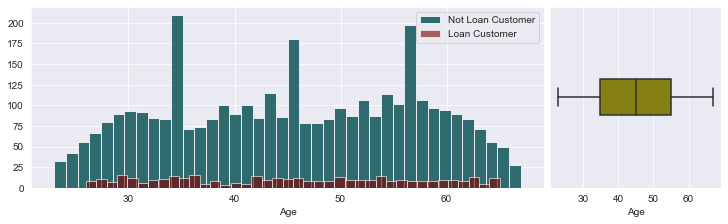

In [175]:
plots("Age")

There aren't any outliers for **Age** feature.

### Feature 1 - Experience

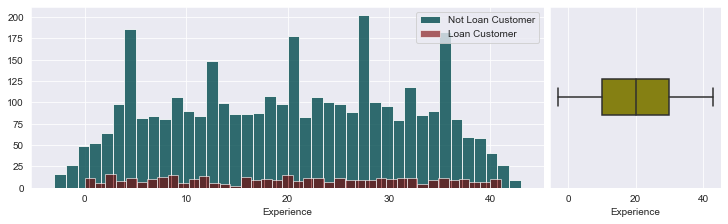

In [176]:
plots("Experience")

There aren't any outliers for **Experience** feature.

### Feature 2 - Income

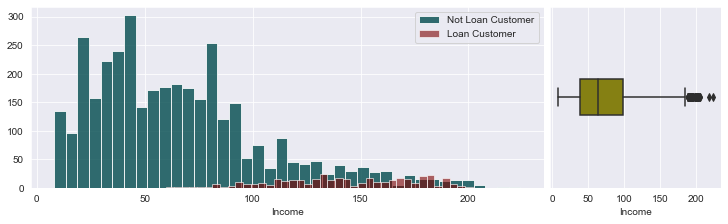

In [177]:
plots("Income")

Distribution of **Income** feature is highly skewed. The samples higher than UW will be replaced with 95th quantile.

In [178]:
Q1 = train_X["Income"].quantile(0.25)
Q3 = train_X["Income"].quantile(0.75)
q95th = train_X["Income"].quantile(0.95)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["Income"] = np.where(train_X["Income"] > UW, q95th, train_X["Income"])

### Feature 3 - Family

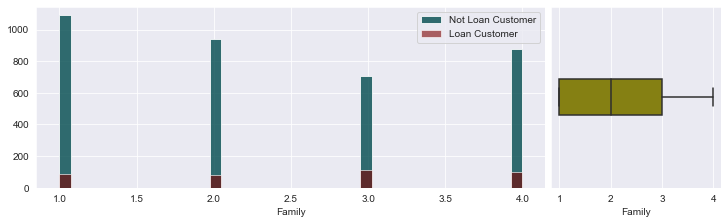

In [179]:
plots("Family")

Family takes 4 discrete values. It's an ordinal categorical variable and there aren't any outliers.

### Feature 4 - CCAvg

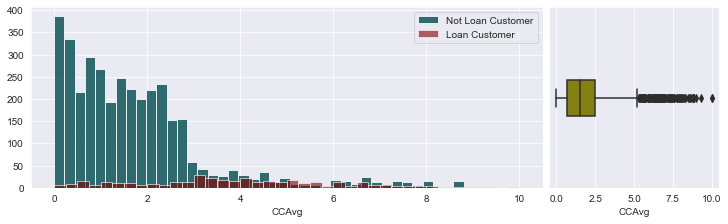

In [180]:
plots("CCAvg")

Distribution of CCAvg feature is highly skewed. The samples higher than UW will be replaced with 95th quantile.

In [181]:
Q1 = train_X["CCAvg"].quantile(0.25)
Q3 = train_X["CCAvg"].quantile(0.75)
q95th = train_X["CCAvg"].quantile(0.95)
IQR = Q3 - Q1
UW = Q3 + 1.5*IQR

train_X["CCAvg"] = np.where(train_X["CCAvg"] > UW, q95th, train_X["CCAvg"])

### Feature 5 - Education

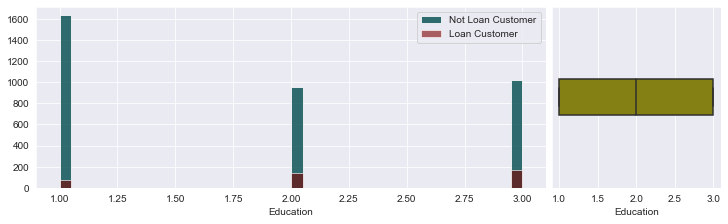

In [182]:
plots("Education")

There aren't any outliers for **Education** feature. In fact, Education is a categorical feature already converted to integer. In this case, integer encoding is suitable beacuse there is an ordinal relationship among education levels.

### Feature 6 - Mortgage

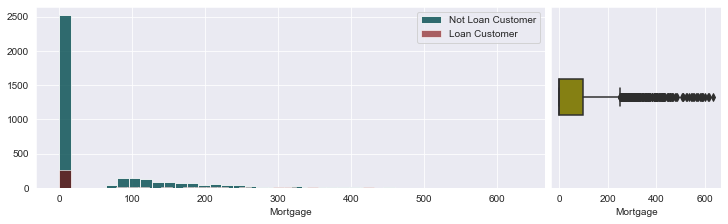

In [183]:
plots("Mortgage")

A lot of customers doesn't have mortgage and the right side of the distribution is almost flat. We can construct an ordinal categorical feature **Mortgage_Int** using Mortgage feature. Then we drop **Mortgage** feature. We apply the same procedure to also test_X.

In [184]:
train_X["Mortgage_Int"] = pd.cut(train_X["Mortgage"],
                                bins=[0,100,200,300,400,500,600,700],
                                labels=[0,1,2,3,4,5,6],
                                include_lowest=True)

train_X.drop("Mortgage", axis=1, inplace=True)

test_X["Mortgage_Int"] = pd.cut(test_X["Mortgage"],
                                bins=[0,100,200,300,400,500,600,700],
                                labels=[0,1,2,3,4,5,6],
                                include_lowest=True)

test_X.drop("Mortgage", axis=1, inplace=True)

### Feature 7 - Securities Account

A customer may have a security account or not. Securities Account is a binary categorical feature and there is no need to make outlier analysis.

In [185]:
train_X["Securities Account"].value_counts()

0    3589
1     411
Name: Securities Account, dtype: int64

### Feature 8 - CD Account

A customer may have a CD account or not. CD Account is a binary categorical feature and there is no need to make outlier analysis.

In [186]:
train_X["CD Account"].value_counts()

0    3767
1     233
Name: CD Account, dtype: int64

### Feature 9 - Online

A customer may use internet banking or not. Online is a binary categorical feature and there is no need to make outlier analysis.

In [187]:
train_X["Online"].value_counts()

1    2354
0    1646
Name: Online, dtype: int64

### Feature 10 - CreditCard

A customer may have credit card or not. CreditCard is a binary categorical feature and there is no need to make outlier analysis.

In [188]:
train_X["CreditCard"].value_counts()

0    2816
1    1184
Name: CreditCard, dtype: int64

## Standardization

Input features are standardized to increase the learning performance. The aim is to transform each feature to have mean of 0 and standard deviation of 1.

In [189]:
feature_names = train_X.columns

scaler = StandardScaler()

# fit to train_X
scaler.fit(train_X)

# transform train_X
train_X = scaler.transform(train_X)
train_X = pd.DataFrame(train_X, columns = feature_names)

# transform test_X
test_X = scaler.transform(test_X)
test_X = pd.DataFrame(test_X, columns = feature_names)

## Correlation Matrix

Now, we inspect the linear correlations between features and also between features and output. Pandas corr function is used to compute correlation matrix and Seaborn heatmap is used for plotting. The semicolon at the end of seaborn command is used to suppress the output other than the plot. Correlation is in interval [-1,1], so our colorbar is.

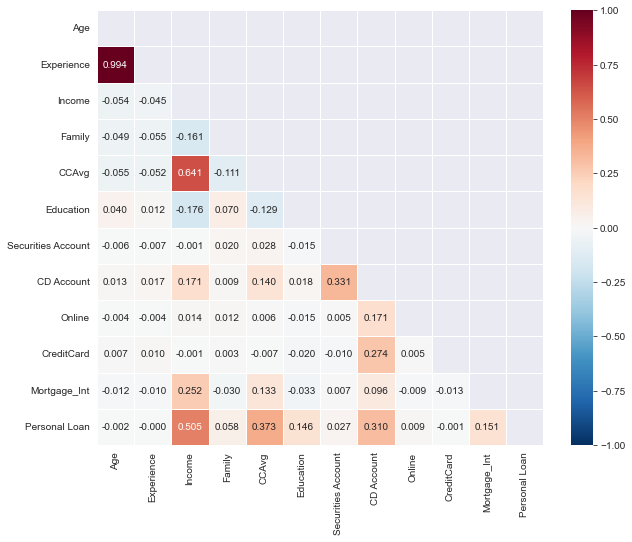

In [190]:
corr_matrix = pd.concat([train_X, train_Y], axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

plt.figure(figsize=(10,8))
sea.heatmap(corr_matrix,annot=True, fmt=".3f",
            vmin=-1, vmax=1, linewidth = 1,
            center=0, mask=mask,cmap="RdBu_r");

**Age** and **Experience** features have very high correlation, 0.99. It is also intuitively understandable that experience increases as age increases. Correlated features degrade the learning performance and causes instability on the models. We drop **Experience** feature from both **train_X** and **test_X**.

In [191]:
train_X.drop("Experience", axis=1, inplace=True)
test_X.drop("Experience", axis=1, inplace=True)

## Prepare Training Data for Meta Learner

There are 2 base learners, **LogisticRegression** and **DecisionTreeClassifier** of scikit-learn. 

We use 5 fold repeated stratified cross validation and n_repeats is 2. There are 10 splits. In each split, 4 folds are used as training data and 1 fold is used as test data.

Temporary base learners are trained on training set, make predictions on test set and then are discarded. Predictions on 10 test sets are concatenated vertically and becomes the training set of meta learner. Base learners and Meta Learner are not trained on the same data. This is done to prevent overfitting. Below cell is used to generate training data for Meta Learner.

In [192]:
# convert dataframes to numpy arrays
np_train_X = train_X.values
np_train_Y = train_Y.values.ravel()
np_test_X = test_X.values
np_test_Y = test_Y.values.ravel()

# create stratified 5 fold
skf_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=0)

vec_X = []
vec_Y = []
# iterate over each split
for train_ind, test_ind in skf_cv.split(np_train_X, np_train_Y):

    # get train and test set for this split
    train_folds_X, test_fold_X = np_train_X[train_ind], np_train_X[test_ind]
    train_folds_Y, test_fold_Y = np_train_Y[train_ind], np_train_Y[test_ind]
    
    # temporary base learners
    cls_1t = LogisticRegression()
    cls_2t = DecisionTreeClassifier(random_state=0)
    
    # fit cls_1t on train_folds_X and predict on test_fold_X 
    cls_1t.fit(train_folds_X, train_folds_Y)
    pred_proba_1 = cls_1t.predict_proba(test_fold_X)[:,1]
    
    # fit cls_2t on train_folds_X and predict on test_fold_X 
    cls_2t.fit(train_folds_X, train_folds_Y)
    pred_proba_2 = cls_2t.predict_proba(test_fold_X)[:,1]

    vec_X.extend(np.concatenate((pred_proba_1.reshape(-1,1),
                                 pred_proba_2.reshape(-1,1)), axis=1))
    vec_Y.extend(test_fold_Y)
    
meta_X = np.array(vec_X)
meta_Y = np.array(vec_Y)

Now, we have data to train our meta learner. Temporary base learners are discarded.

## Train Base Learners

After generating training data for Meta Learner, base learners (LogisticRegression and DecisionTreeClassifier) are trained on whole training data, np_train_X and np_train_Y.

In [193]:
# base Learners
cls_1 = LogisticRegression()
cls_2 = DecisionTreeClassifier(random_state=0)

# fit cls_1 on train_X
cls_1.fit(np_train_X, np_train_Y)
# fit cls_2 on train_X
cls_2.fit(np_train_X, np_train_Y);

## Test Base Learners

Base learners are evaluated on np_test_X. Their classification reports are printed.

In [199]:
pred_1_test_X = cls_1.predict(np_test_X)
print("Classification report for base learner 1\n")
print(classification_report(np_test_Y, pred_1_test_X,
                            digits = 4,
                            target_names=["Not Loan Customer",
                                          "Loan Customer"]))

confusion_matrix(np_test_Y, pred_1_test_X) 



Classification report for base learner 1

                   precision    recall  f1-score   support

Not Loan Customer     0.9651    0.9801    0.9726       904
    Loan Customer     0.7805    0.6667    0.7191        96

         accuracy                         0.9500      1000
        macro avg     0.8728    0.8234    0.8458      1000
     weighted avg     0.9474    0.9500    0.9482      1000



array([[886,  18],
       [ 32,  64]])

In [198]:

pred_2_test_X = cls_2.predict(np_test_X)
print("\n\nClassification report for base learner 2\n")
print(classification_report(np_test_Y, pred_2_test_X,
                            digits = 4,
                            target_names=["Not Loan Customer",
                                          "Loan Customer"]))
confusion_matrix(np_test_Y, pred_2_test_X)                                         



Classification report for base learner 2

                   precision    recall  f1-score   support

Not Loan Customer     0.9912    0.9945    0.9928       904
    Loan Customer     0.9462    0.9167    0.9312        96

         accuracy                         0.9870      1000
        macro avg     0.9687    0.9556    0.9620      1000
     weighted avg     0.9869    0.9870    0.9869      1000



array([[899,   5],
       [  8,  88]])

## Train Meta Learner

Meta learner XGBoost Classifier, is itself a gradient boosting ensemble that in our case has 6 sequential estimators. So, we use an ensemble as the meta learner of our stacking ensemble.

In [196]:
meta = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                         colsample_bylevel=1, colsample_bynode=1,
                         colsample_bytree=1, gamma=10, gpu_id=-1,
                         learning_rate=0.1, max_delta_step=0,
                         max_depth=4, n_estimators=6, n_jobs=0,
                         random_state=0, subsample=1)

meta.fit(meta_X, meta_Y);

[23:00:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Test Stacking Ensemble

We process np_test_X with our base learners. Then, we feed their outputs to Meta Learner and evaluate its output. Then, classification report of Stacking Ensemble is printed.

In [197]:
prob_1_test_X = cls_1.predict_proba(np_test_X)[:,1]
prob_2_test_X = cls_2.predict_proba(np_test_X)[:,1]

level_1_in_X = np.concatenate((prob_1_test_X.reshape(-1,1),
                               prob_2_test_X.reshape(-1,1)), axis=1)

stacking_pred = meta.predict(level_1_in_X)
print("Classification report for Stacking Ensemble\n")
print(classification_report(np_test_Y, stacking_pred,
                            digits = 4,
                            target_names=["Not Loan Customer",
                                          "Loan Customer"]))


Classification report for Stacking Ensemble

                   precision    recall  f1-score   support

Not Loan Customer     0.9901    0.9967    0.9934       904
    Loan Customer     0.9667    0.9062    0.9355        96

         accuracy                         0.9880      1000
        macro avg     0.9784    0.9515    0.9644      1000
     weighted avg     0.9879    0.9880    0.9878      1000



Performance of base learners, LogisticRegression and DecisionTreeClassifier are already very high. If we look at the F1 scores, we see that even in this case, Meta Learner has positive contribution.

Just like other ensemble methods, performance gain provided by stacking ensemble changes according to dataset under consideration. In some cases, base learners are enough, in some cases, performance gain can be moderate or higher.